# Set up

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clustering

**Introduction: Classification *vs* Clustering**

In [31]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

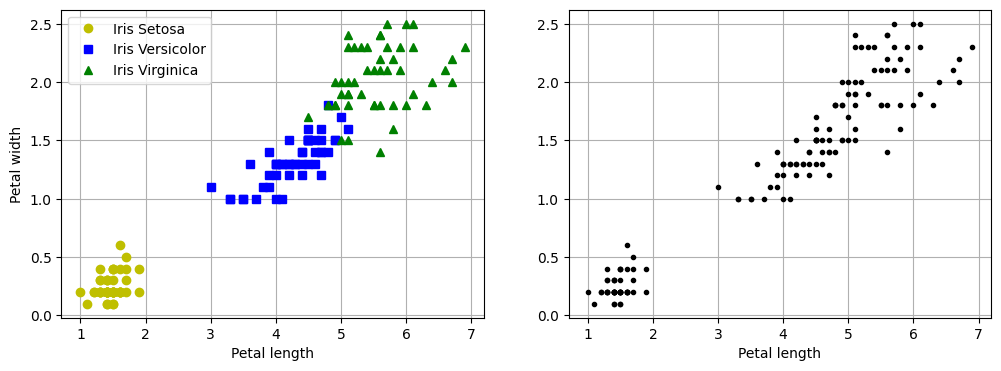

In [32]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(X[:, 2][y == 0], X[:, 3][y == 0], "yo", label="Iris Setosa")
plt.plot(X[:, 2][y == 1], X[:, 3][y == 1], "bs", label="Iris Versicolor")
plt.plot(X[:, 2][y == 2], X[:, 3][y == 2], "g^", label="Iris Virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(X[:, 2], X[:, 3], "k.")
plt.xlabel("Petal length")
plt.grid()

plt.show()

**Note:** The next code cell shows how a Gaussian Mixture model (explained later in this notebook) can actually these clusters quite well using all 4 features: petal length and width, sepal length and width.   

In [33]:
from sklearn.mixture import GaussianMixture

y_predict = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Next, we map each cluster to a class. Each cluster will have a unique id and here we try to map the cluster's id to the class in the dataset. Instead of hard coding the mapping, we will use `scipy.stats.mode()` function.

In [34]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_predict[y == class_id])
    mapping[mode] = class_id

Then we transform the predicted array to use the class in the dataset, instead of its self-created id, and plot the result.

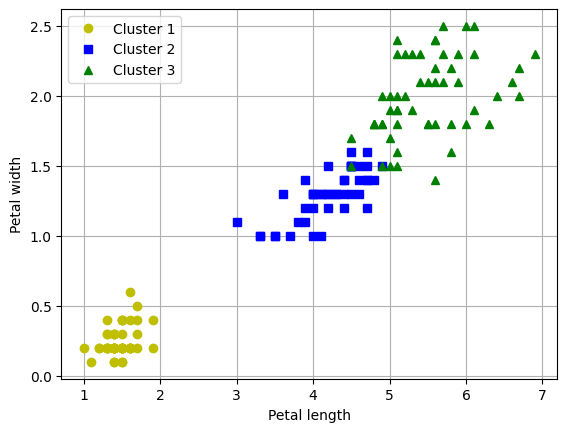

In [35]:
y_predict = np.array([mapping[cluster_id] for cluster_id in y_predict])

plt.plot(X[y_predict == 0, 2], X[y_predict == 0, 3], "yo", label="Cluster 1")
plt.plot(X[y_predict == 1, 2], X[y_predict == 1, 3], "bs", label="Cluster 2")
plt.plot(X[y_predict == 2, 2], X[y_predict == 2, 3], "g^", label="Cluster 3")
plt.grid()
plt.legend()
plt.xlabel("Petal length")
plt.ylabel("Petal width")

plt.show()

What's the ratio of iris plant we assigned to the right cluster?

In [36]:
(y_predict == y).sum() / len(y)

0.9666666666666667

And we only misclassify 5 of them.

In [37]:
len(y) - (y_predict == y).sum()

5

## K-means

**Fit and predict**

Here, we train a K-means clustering algorithm on a dataset of blobs. It will try to find the centroid of each blob and assign each instance to the closet blob.

In [38]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]]
)
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(
    n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7
)

Here, `random_state` is set to 1, to ensure that the centroids will be at the blob centers. The detail will be explained further as you go.

In [39]:
k = 5
k_means = KMeans(n_clusters=k, n_init=10, random_state=1)
y_predict = k_means.fit_predict(X)

Then we will plot them.

In [40]:
def plot_cluster(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

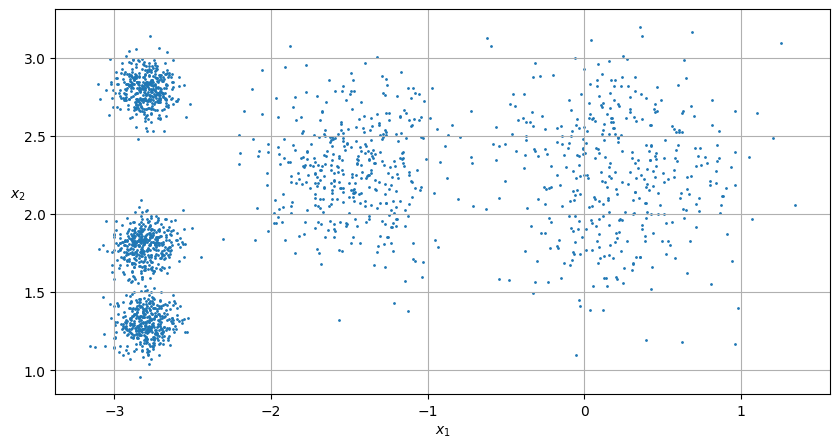

In [41]:
plt.figure(figsize=(10, 5))
plot_cluster(X)
plt.grid()

plt.show()

Each instance is assigned to one of the 5 clusters.

In [42]:
y_predict

array([1, 4, 0, ..., 3, 0, 4], dtype=int32)

In [43]:
y_predict is k_means.labels_

True

The following 5 centroids (i.e. cluster centers) were estimated as:  

In [44]:
k_means.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80037642,  1.30082566],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80389616,  1.80117999]])

Note that `KMeans` preserves the label of each instance it was trained on. This label is the index of the cluster it belongs to, not to be confused with the labels in the training set. 

In [45]:
k_means.labels_

array([1, 4, 0, ..., 3, 0, 4], dtype=int32)

Of course, we can predict the cluster new instances may belong to. 

In [46]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
k_means.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

**Decision boundaries**

In [47]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)

In [48]:
def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="o",
        s=35,
        linewidths=8,
        color=circle_color,
        zorder=10,
        alpha=0.9,
    )
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=2,
        linewidths=12,
        color=cross_color,
        zorder=11,
        alpha=1,
    )

In [49]:
def plot_decision_boundaries(
    clusterer,
    X,
    resolution=1000,
    show_centroids=True,
    show_xlabels=True,
    show_ylabels=True,
):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution),
    )
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(
        Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k"
    )
    plot_data(X)

    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)

    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

The result is a *Voronoi* diagram.

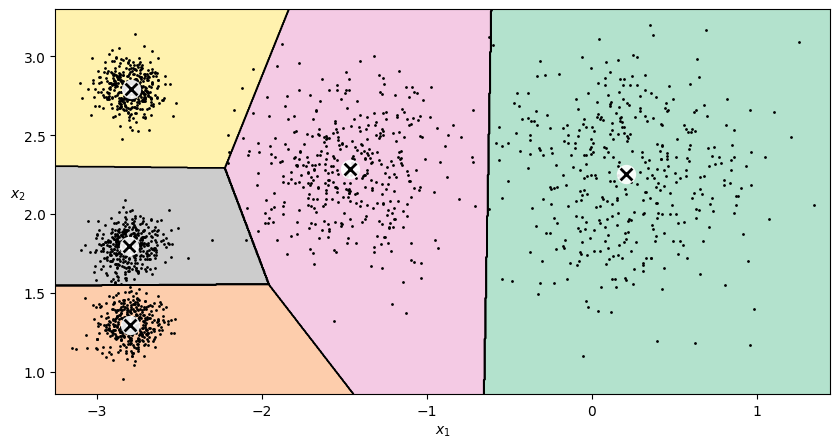

In [50]:
plt.figure(figsize=(10, 5))
plot_decision_boundaries(k_means, X)
plt.show()

Great! Some instances along the edge may be assigned to the wrong cluster, but in general, our model work very good.